# NN Experiments with different methods

- SVRG vs L-SVRG
- SARAH vs PAGE


In [205]:
import operator
import time
import warnings
from itertools import accumulate
from typing import Callable, Iterable, Literal, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.utils.data
from cycler import cycler
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [206]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [207]:
MANUAL_SEED = 42
np.random.seed(MANUAL_SEED)

## Data loading


In [208]:
def load_MNIST_binary() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df = pd.read_csv("../data/interim/mnist_binary.csv", index_col=None)

    y, X = df.iloc[:, 0].to_numpy(), df.iloc[:, 1:].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    return X_train, y_train, X_test, y_test


def load_MNIST() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    df = pd.read_csv("../data/raw/mnist.csv", index_col=None)

    y, X = df.iloc[:, 0].to_numpy(), df.iloc[:, 1:].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42
    )

    return X_train, y_train, X_test, y_test


def load_mushrooms() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    data = load_svmlight_file("../data/raw/mushrooms.txt")
    X, y = data[0].toarray(), data[1]
    y = 2 * y - 3

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    return X_train, y_train, X_test, y_test


def load_dataset(
    dataset: Literal["MNIST_binary"] | Literal["mushrooms"] | Literal["MNIST"],
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    if dataset == "MNIST_binary":
        return load_MNIST_binary()
    if dataset == "MNIST":
        return load_MNIST()
    return load_mushrooms()

In [209]:
X_train, Y_train, X_test, Y_test = load_dataset("MNIST_binary")

In [210]:
print(f"{X_train.shape=}, {Y_train.shape=}")
print(f"{X_test.shape=}, {Y_test.shape=}")

X_train.shape=(1800, 784), Y_train.shape=(1800,)
X_test.shape=(200, 784), Y_test.shape=(200,)


In [211]:
DATA_SIZE = Y_train.shape[0]
NUM_LABELS = len(np.unique(Y_train))

In [212]:
ENCODE_DICT = {
    label: i for i, label in enumerate(np.unique(np.concatenate([Y_train, Y_test])))
}
DECODE_DICT = {i: label for label, i in ENCODE_DICT.items()}

## Problems


In [213]:
class Problem:
    def get_value(self, w: np.ndarray, batch_idx: Optional[int] = None) -> float:
        raise NotImplementedError

    def get_gradient(self, w: np.ndarray, batch_idx: Optional[int] = None) -> np.ndarray:
        raise NotImplementedError

    def get_batch_size(self) -> int:
        raise NotImplementedError

    def get_batches_number(self) -> int:
        raise NotImplementedError

    def get_data_size(self) -> int:
        raise NotImplementedError

    def predict(self, x_values: np.ndarray, w: np.ndarray) -> np.ndarray:
        raise NotImplementedError

    def get_batch_indices(self, n: int) -> np.ndarray:
        raise NotImplementedError

In [214]:
def batch_data(data: list, batch_size: int) -> list:
    return [data[i : i + batch_size] for i in range(0, len(data), batch_size)]


def generate_batches(
    x_values: np.ndarray,
    y_values: np.ndarray,
    batch_size: int,
    seed: Optional[float] = 42,
) -> list[list[tuple[np.ndarray, float]]]:
    data = list(zip(x_values, y_values))
    if batch_size == 0:
        return [data]
    if seed is not None:
        np.random.seed(seed)
    np.random.shuffle(data)
    return batch_data(data, batch_size)


def divide_into_s_batches(
    x_values: np.ndarray,
    y_values: np.ndarray,
    s: int,
    seed: Optional[float] = 42,
) -> list[list[tuple[np.ndarray, float]]]:
    return generate_batches(x_values, y_values, DATA_SIZE // s, seed)[:s]

In [215]:
def labels_to_vectors(labels: np.ndarray, map_dict: Optional[dict] = None) -> np.ndarray:
    vectorized = []
    local_map_dict = (
        map_dict
        if map_dict is not None
        else {label: i for i, label in enumerate(np.unique(labels))}
    )
    for label in labels:
        zeroes = np.zeros(NUM_LABELS)
        zeroes[local_map_dict[label]] = 1.0
        vectorized.append(zeroes)
    return np.array(vectorized)

### Basic Logistic Regression


### Code


In [216]:
class BasicLogisticRegression(Problem):
    def _to_tensor(self, x: np.ndarray) -> torch.Tensor:
        return torch.tensor(x).float().to(self.device)

    def _to_numpy(self, x: torch.Tensor) -> np.ndarray:
        return x.cpu().numpy()

    def _get_data(self, batch_idx: Optional[int]) -> tuple[torch.Tensor, torch.Tensor]:
        if batch_idx is None:
            # choose uniformly from batches
            idx = np.random.randint(0, self.num_batches)
            return self.batched_data[idx]

        if batch_idx < 0:
            # return full data
            return self.all_data

        return self.batched_data[batch_idx]

    def _get_result(self, w: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return F.softmax(x @ w)
        # return x @ w

    def _get_loss(self, res: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        return F.cross_entropy(res, targets)

    def _get_value(
        self, w: np.ndarray, batch_idx: Optional[int], requires_grad: bool
    ) -> tuple[torch.Tensor, torch.Tensor]:
        data = self._get_data(batch_idx)
        w_ = self._to_tensor(w)
        if requires_grad:
            w_.requires_grad_()

        x = data[0].to(self.device)
        y = data[1].to(self.device)
        res = self._get_result(w_, x)
        # print(res)
        loss_res = self._get_loss(res, y)
        # print(loss_res)

        return loss_res, w_

    def __init__(
        self,
        batched_data: list[list[tuple[np.ndarray, float]]],
        label_encode_dict: dict = ENCODE_DICT,
        label_decode_dict: dict = DECODE_DICT,
        seed: float = MANUAL_SEED,
        device: torch.device = DEVICE,
    ) -> None:
        np.random.seed(seed)
        torch.manual_seed(seed)
        self.device = device
        self.label_encode_dict = label_encode_dict
        self.label_decode_dict = label_decode_dict

        self.batched_data: list[tuple[torch.Tensor, torch.Tensor]] = []

        all_values = []
        all_targets = []
        for d in batched_data:
            xs, ys = zip(*d)
            targets = labels_to_vectors(ys, map_dict=self.label_encode_dict)
            all_values.extend(xs)
            all_targets.extend(targets)
            self.batched_data.append(
                (torch.tensor(xs).float(), torch.tensor(targets).float())
            )

        self.all_data: tuple[torch.Tensor, torch.Tensor] = (
            torch.tensor(all_values).float(),
            torch.tensor(all_targets).float(),
        )

        self.num_batches = len(self.batched_data)
        self.batch_size = len(self.batched_data[0][0])

    def get_value(self, w: np.ndarray, batch_idx: Optional[int] = None) -> float:
        res, _ = self._get_value(w, batch_idx, requires_grad=False)
        return res.item()

    def get_gradient(self, w: np.ndarray, batch_idx: Optional[int] = None) -> np.ndarray:
        res, w_ = self._get_value(w, batch_idx, requires_grad=True)
        res.backward()
        return self._to_numpy(w_.grad)

    def get_batch_size(self):
        return self.batch_size

    def get_batches_number(self):
        return self.num_batches

    def get_data_size(self):
        return len(self.all_data)

    def predict(self, x_values: np.ndarray, w: np.ndarray) -> np.ndarray:
        res = self._get_result(self._to_tensor(w), self._to_tensor(x_values))
        return np.array(
            [
                self.label_decode_dict[int(encoded)]
                for encoded in np.argmax(self._to_numpy(res), axis=1)
            ]
        )

    def get_batch_indices(self, n: int = 1) -> np.ndarray:
        return np.random.choice(list(range(self.num_batches)), n, replace=False)

In [229]:
blr_ = BasicLogisticRegression(generate_batches(X_train, Y_train, 10))

np.random.seed(420)
w_ = np.random.rand(X_train.shape[1], NUM_LABELS)

print(f"{blr_.get_value(w_,-1)=}")
print(f"{blr_.get_gradient(w_).shape=}")

blr_.get_value(w_,-1)=0.9815033674240112
blr_.get_gradient(w_).shape=(784, 2)


blr*.get_value(w*,-1)=0.6931473016738892


## Methods


Maximum iterations: 1000

Required precision $\varepsilon  =10^{-5}$

$\frac{\| \nabla f(x^k) \|}{\| \nabla f(x^0) \|}$ is used as default convergence criterion.


In [218]:
NUM_ITERATIONS = 1000
NUM_ITERATIONS = 100
EPSILON = 1e-5

np.random.seed(420)
START_POINT = np.random.randn(X_train.shape[1], NUM_LABELS)

In [219]:
IterationType = Literal["iterations"] | Literal["gradients"] | Literal["time"]


class Method:
    def _log_accuracy(self) -> float:
        accuracy = 0
        if not self.accuracy_logging:
            return accuracy

        predictions = self.f.predict(self.test_values, self.w_curr)

        if len(predictions) == 0:
            self.accuracy_logs.append(accuracy)
            return accuracy

        accuracy = (predictions == self.test_targets).sum() / self.test_targets.shape[0]
        self.accuracy_logs.append(accuracy)
        return accuracy

    def _log_data_points(self):
        accuracy = 0
        if not self.accuracy_logging:
            return accuracy

        predictions = self.f.predict(self.test_values, self.w_curr)

        if len(predictions) == 0:
            self.accuracy_logs.append(accuracy)
            return accuracy

        accuracy = (predictions == self.test_targets).sum() / self.test_targets.shape[0]
        self.accuracy_logs.append(accuracy)
        return accuracy

    def _accumulate(self, values: Iterable) -> list:
        return list(accumulate(values, operator.add))

    def __init__(
        self,
        name: str,
        f: Problem,
        w_0: np.ndarray,
        epsilon: float = EPSILON,
        verbose: bool = False,
    ) -> None:
        """Method base class

        Args:
            name (str): Method name
            f (Function)
            w_0 (np.ndarray): starting point
            epsilon (float):Required precision. Defaults to EPSILON
            verbose (bool): Defaults to False
        """

        self.name = name
        self.f = f
        self.w_0 = w_0.copy()
        self.epsilon = epsilon
        self.verbose = verbose

        self.accuracy_logging = False

        self.func_batch_size = f.get_batch_size()

        self.get_iterations_check: dict[IterationType, Callable[[], float]] = {
            "iterations": lambda: self.total_pass_iterations,
            "gradients": lambda: self.total_used_gradients,
            "time": lambda: self.total_passed_time,
        }

        self.get_iterations_update: dict[IterationType, Callable[[], float]] = {
            "iterations": lambda: 1,
            "gradients": lambda: self.used_gradients,
            "time": lambda: self.passed_time,
        }

        self.reset()

    def enable_accuracy_logging(self, test_values: np.ndarray, test_targets: np.ndarray):
        self.accuracy_logging = True
        self.test_values = test_values
        self.test_targets = test_targets

    def disable_accuracy_logging(self):
        self.accuracy_logging = False

    def predict(self, x_values: np.ndarray) -> np.ndarray:
        return self.f.predict(x_values, self.w_sol)

    def get_name(self) -> str:
        return self.name

    def get_solution(self) -> np.ndarray:
        return self.w_sol

    def get_pass_iterations_logs(self) -> list[int]:
        return list(range(self.total_pass_iterations + 1))

    def get_used_gradients_logs(self) -> list[int]:
        return self.used_gradients_logs

    def get_time_logs(self) -> list[float]:
        return self.time_logs

    def get_accumulated_time_logs(self) -> list[float]:
        return self.time_logs

    def get_accuracy_logs(self) -> list[float]:
        return self.accuracy_logs

    def get_criterion_logs(self) -> list[float]:
        return self.criterion_logs

    def update(self, iteration: int) -> bool:
        raise NotImplementedError

    def calculate_criterion(self, k: int) -> float:
        full_grad_current = self.f.get_gradient(self.w_curr, -1)  # on full_data
        return float(
            np.linalg.norm(full_grad_current) / np.linalg.norm(self.full_grad_0)  # type: ignore
        )

    def reset(self):
        self.criterion_logs = []
        self.time_logs = []
        self.accuracy_logs = []
        self.used_gradients_logs = []

        self.used_gradients = 0
        self.transmitted_info = 0
        self.communications_number = 0
        self.passed_time = 0

        self.total_used_gradients = 0
        self.total_pass_iterations = 0
        self.total_passed_time = 0

        self.w_prev = self.w_0.copy()
        self.w_curr = self.w_0.copy()
        self.w_sol = self.w_0.copy()

        self.full_grad_0 = self.f.get_gradient(self.w_0, -1)

    def start(
        self,
        max_iterations: float = NUM_ITERATIONS,
        iteration_type: IterationType = "iterations",
    ) -> np.ndarray:
        """Start iterating

        Returns:
            np.ndarray: solution
        """
        self.reset()

        if not self.verbose:
            progress_bar = tqdm(
                total=max_iterations, desc=self.name, leave=True, position=0
            )

        iterations_check = self.get_iterations_check[iteration_type]
        iterations_update = self.get_iterations_update[iteration_type]

        # logging
        self.time_logs.append(0)
        self.criterion_logs.append(self.calculate_criterion(0))
        self.used_gradients_logs.append(0)
        accuracy = self._log_accuracy()

        while iterations_check() < max_iterations:
            k = self.total_pass_iterations

            self.used_gradients = 0
            self.transmitted_info = 0
            self.communications_number = 0

            start_time = time.time()
            succeeded = self.update(k)
            finish_time = time.time()
            self.passed_time = finish_time - start_time

            if not succeeded:  # diverges
                break

            self.total_pass_iterations += 1
            self.total_used_gradients += self.used_gradients
            self.total_passed_time += self.passed_time

            # logging
            self.time_logs.append(self.total_passed_time)
            criterion_value = self.calculate_criterion(k)
            self.criterion_logs.append(criterion_value)
            self.used_gradients_logs.append(self.total_used_gradients)
            accuracy = self._log_accuracy()

            if not self.verbose:
                info_dict = {"time": self.passed_time, "criterion": criterion_value}
                if self.accuracy_logging:
                    info_dict.update({"accuracy": accuracy})

                progress_bar.set_postfix(info_dict)  # type: ignore
                progress_bar.update(iterations_update())  # type: ignore

            if np.isnan(criterion_value):  # diverges
                break
            if criterion_value < self.epsilon:
                break

        self.w_sol = self.w_curr.copy()

        if not self.verbose:
            progress_bar.close()  # type: ignore

        return self.w_sol

### SVRG


In [220]:
class SVRG(Method):
    def __init__(
        self,
        f: Problem,
        w_0: np.ndarray,
        step_size: Callable[[int], float],
        epoch_length: int,
        epsilon: float = EPSILON,
        verbose: bool = False,
        label: Optional[str] = None,
    ) -> None:
        name = "SVRG"
        if label is not None:
            name = f"{name} | {label}"
        super().__init__(name, f, w_0, epsilon, verbose)
        self.step_size = step_size
        self.epoch_length = epoch_length

        self.batch_size = self.f.get_batch_size()
        self.batches_number = f.get_batches_number()
        self.data_size = f.get_data_size()

    def update(self, iteration: int) -> bool:
        learning_rate = self.step_size(iteration)

        w_tilde = self.w_curr.copy()
        full_grad = self.f.get_gradient(w_tilde, -1)

        inside_w = w_tilde.copy()
        aggregated_w = inside_w.copy()

        for _ in range(self.epoch_length):
            i = np.random.randint(self.batches_number)

            g_k = (
                self.f.get_gradient(inside_w, i)
                - self.f.get_gradient(w_tilde, i)
                + full_grad
            )
            inside_w = inside_w - learning_rate * g_k
            aggregated_w += inside_w

        next_w = aggregated_w / self.epoch_length

        self.w_prev = self.w_curr.copy()
        self.w_curr = next_w.copy()

        self.used_gradients = self.data_size + 2 * self.epoch_length * self.batch_size

        return True

### L-SVRG


In [221]:
class LSVRG(Method):
    def __init__(
        self,
        f: Problem,
        w_0: np.ndarray,
        step_size: Callable[[int], float],
        probability: float,
        epsilon: float = EPSILON,
        verbose: bool = False,
        label: Optional[str] = None,
    ) -> None:
        name = "L-SVRG"
        if label is not None:
            name = f"{name} | {label}"
        super().__init__(name, f, w_0, epsilon, verbose)
        self.step_size = step_size
        self.probability = probability

        self.batch_size = self.f.get_batch_size()
        self.batches_number = f.get_batches_number()
        self.data_size = f.get_data_size()

    def reset(self):
        super().reset()
        self.w_tilde = self.w_0.copy()
        self.grad_w_tilde = self.f.get_gradient(self.w_tilde, -1)

    def update(self, iteration: int) -> bool:
        i = np.random.randint(self.batches_number)
        grad = (
            self.f.get_gradient(self.w_curr, i)
            - self.f.get_gradient(self.w_tilde, i)
            + self.grad_w_tilde
        )

        next_w = self.w_curr - self.step_size(iteration) * grad

        if np.random.random() < self.probability:
            self.w_tilde = self.w_curr.copy()
            self.grad_w_tilde = self.f.get_gradient(self.w_tilde, -1)

            self.used_gradients += self.data_size

        self.w_prev = self.w_curr.copy()
        self.w_curr = next_w.copy()

        self.used_gradients += 2 * self.batch_size

        return True

#### SARAH


In [222]:
class SARAH(Method):
    def __init__(
        self,
        f: Problem,
        w_0: np.ndarray,
        step_size: Callable[[int], float],
        epoch_length: int,
        epsilon: float = EPSILON,
        verbose: bool = False,
        label: Optional[str] = None,
    ) -> None:
        name = "SARAH"
        if label is not None:
            name = f"{name} | {label}"
        super().__init__(name, f, w_0, epsilon, verbose)
        self.step_size = step_size
        self.epoch_length = epoch_length

        self.batch_size = self.f.get_batch_size()
        self.batches_number = f.get_batches_number()
        self.data_size = f.get_data_size()

    def update(self, iteration: int) -> bool:
        learning_rate = self.step_size(iteration)

        ws = [self.w_curr.copy()]
        v = self.f.get_gradient(self.w_curr, -1)
        ws.append(self.w_curr - learning_rate * v)

        stop_idx = np.random.randint(self.epoch_length)

        for _ in range(stop_idx - 1):
            i = np.random.randint(self.batches_number)

            v = self.f.get_gradient(ws[-1], i) - self.f.get_gradient(ws[-2], i) + v
            ws.append(ws[-1] - learning_rate * v)

        next_w = ws[stop_idx]

        self.w_prev = self.w_curr.copy()
        self.w_curr = next_w.copy()

        self.used_gradients = self.data_size + 2 * (stop_idx + 1) * self.batch_size

        return True

### PAGE


In [223]:
class PAGE(Method):
    def _gradient_on_primary_batch(self, w: np.ndarray) -> np.ndarray:
        return (
            np.sum(
                [
                    self.f.get_gradient(w, batch_idx=i)
                    for i in self.f.get_batch_indices(self.secondary_batch_size)
                ],
                axis=0,
            )
            / self.secondary_batch_size
        )

    def __init__(
        self,
        f: Problem,
        w_0: np.ndarray,
        step_size: Callable[[int], float],
        probability: float,
        epsilon: float = EPSILON,
        verbose: bool = False,
        label: Optional[str] = None,
    ) -> None:
        name = "PAGE"
        if label is not None:
            name = f"{name} | {label}"

        self.batch_size = f.get_batch_size()
        self.secondary_batch_size = self.batch_size
        self.primary_batch_size = self.secondary_batch_size**2
        super().__init__(name, f, w_0, epsilon, verbose)
        self.step_size = step_size
        self.probability = probability

        self.batches_number = f.get_batches_number()
        self.data_size = f.get_data_size()

    def reset(self):
        super().reset()
        self.g = self._gradient_on_primary_batch(self.w_0)
        self.ws = []

    def get_solution(self) -> np.ndarray:
        return np.random.choice(self.ws)

    def update(self, iteration: int) -> bool:
        next_w = self.w_curr - self.step_size(iteration) * self.g

        self.w_prev = self.w_curr.copy()
        self.w_curr = next_w.copy()

        if np.random.random() < self.probability:
            self.g = self._gradient_on_primary_batch(self.w_curr)

            self.used_gradients = self.primary_batch_size

            return True

        i = np.random.randint(self.batches_number)
        self.g = (
            self.g
            + self.f.get_gradient(self.w_curr, batch_idx=i)
            - self.f.get_gradient(self.w_prev, batch_idx=i)
        )

        self.used_gradients = 2 * self.secondary_batch_size

        return True

## Utilities


In [224]:
PREDEFINED_COLORS = [
    "#ffa500",
    "#c83cbc",
    "#1c1c84",
    "#ff0000",
    "#08a4a7",
    "#008000",
]


AxesValues = (
    Literal["criterion"]
    | Literal["accuracy"]
    | Literal["iterations"]
    | Literal["time"]
    | Literal["used_gradients"]
    | Literal["log_used_gradients"]
)
PREDEFINED_AXES_VALUES: dict[AxesValues, dict] = {
    "criterion": {
        "name": "Criterion",
        "label": "Criterion, log scale",
        "get_data": lambda m: m.get_criterion_logs(),
        "log": True,
    },
    "accuracy": {
        "name": "Accuracy",
        "label": "Accuracy",
        "get_data": lambda m: m.get_accuracy_logs(),
        "log": False,
    },
    "iterations": {
        "name": "Iterations",
        "label": "Iterations",
        "get_data": lambda m: m.get_pass_iterations_logs(),
        "log": False,
    },
    "time": {
        "name": "Time",
        "label": "Running time, seconds",
        "get_data": lambda m: m.get_accumulated_time_logs(),
        "log": False,
    },
    "used_gradients": {
        "name": "Used gradients",
        "label": "Used gradients",
        "get_data": lambda m: m.get_used_gradients_logs(),
        "log": False,
    },
    "log_used_gradients": {
        "name": "Used gradients",
        "label": "Used gradients, log scale",
        "get_data": lambda m: m.get_used_gradients_logs(),
        "log": True,
    },
}


PlotDescription = tuple[AxesValues, AxesValues]


def draw_method_plots(
    methods: list[Method],
    title: str,
    plots: list[PlotDescription],
    ylim=None,
    plot_width: float = 16,
    plot_height: float = 7,
    use_rainbow: bool = False,
    use_common_legend: bool = True,
):
    num_plots = len(plots)
    if use_rainbow:
        num_colors = len(methods)
        cm = plt.get_cmap("gist_rainbow")
        colors = [cm(1.0 * i / num_colors) for i in range(num_colors)]
    else:
        colors = PREDEFINED_COLORS

    style_cycler = cycler(linestyle=["-", "--", ":", "-."]) * cycler(color=colors)

    fig, axs = plt.subplots(num_plots, 1, figsize=(plot_width, plot_height * num_plots))
    fig.suptitle(title, fontsize=14)
    axs_list = [axs] if num_plots == 1 else list(axs.flat)

    for ax in axs_list:
        ax.grid()
        ax.set_prop_cycle(style_cycler)
        if ylim is not None:
            ax.set_ylim(top=ylim)

    for ax, (p1, p2) in zip(axs_list, plots):
        p1_data = PREDEFINED_AXES_VALUES[p1]
        p2_data = PREDEFINED_AXES_VALUES[p2]

        ax.set_title(f"{p2_data['name']} over {p1_data['name']}")
        ax.set(xlabel=p1_data["label"], ylabel=p2_data["label"])

        if p1_data["log"]:
            ax.set_xscale("log")
        if p2_data["log"]:
            ax.set_yscale("log")

        for method in methods:
            label = method.name

            x_values = p1_data["get_data"](method)
            y_values = p2_data["get_data"](method)

            ax.plot(x_values, y_values, label=label)
            ax.scatter(x_values[-1], y_values[-1], s=15)

    if use_common_legend:
        lines_labels = [axs_list[0].get_legend_handles_labels()]
        lines, labels = [sum(x, []) for x in zip(*lines_labels)]
        fig.legend(
            lines,
            labels,
            scatterpoints=1,
            markerscale=3,
            loc="outside lower center",
            ncol=min(5, len(methods)),
            bbox_to_anchor=(0.5, -0.05),
        )
    else:
        if len(methods) > 1:
            for ax in axs_list:
                ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1))

    plt.tight_layout()
    plt.subplots_adjust(
        top=1 - 0.1 / (num_plots**0.5), bottom=0.12 / (num_plots**2), hspace=0.15
    )

## Basic LR Experiments


### Ex1. SVRG vs L-SVRG


In [228]:
SVRG_LR_DICT: dict[str, Callable[[int], float]] = {
    "SVRG": lambda _: 1e-1,
    "LSVRG": lambda _: 1e-1,
}
SVRG_S = 100
SVRG_P = 1 / SVRG_S


svrgs: list[Method] = [
    SVRG(
        BasicLogisticRegression(divide_into_s_batches(X_train, Y_train, s=SVRG_S)),
        START_POINT,
        SVRG_LR_DICT["SVRG"],
        epoch_length=int(1 / SVRG_P),
    ),
    LSVRG(
        BasicLogisticRegression(divide_into_s_batches(X_train, Y_train, s=SVRG_S)),
        START_POINT,
        SVRG_LR_DICT["LSVRG"],
        probability=SVRG_P,
    ),
]

for svrg in svrgs:
    svrg.enable_accuracy_logging(X_test, Y_test)
    _ = svrg.start(max_iterations=1e5, iteration_type="gradients")

SVRG: 100856it [00:07, 12684.03it/s, time=0.266, criterion=0.0525, accuracy=0.97]                              
L-SVRG: 100020it [00:38, 2591.53it/s, time=0.00501, criterion=0.0198, accuracy=0.985]                             


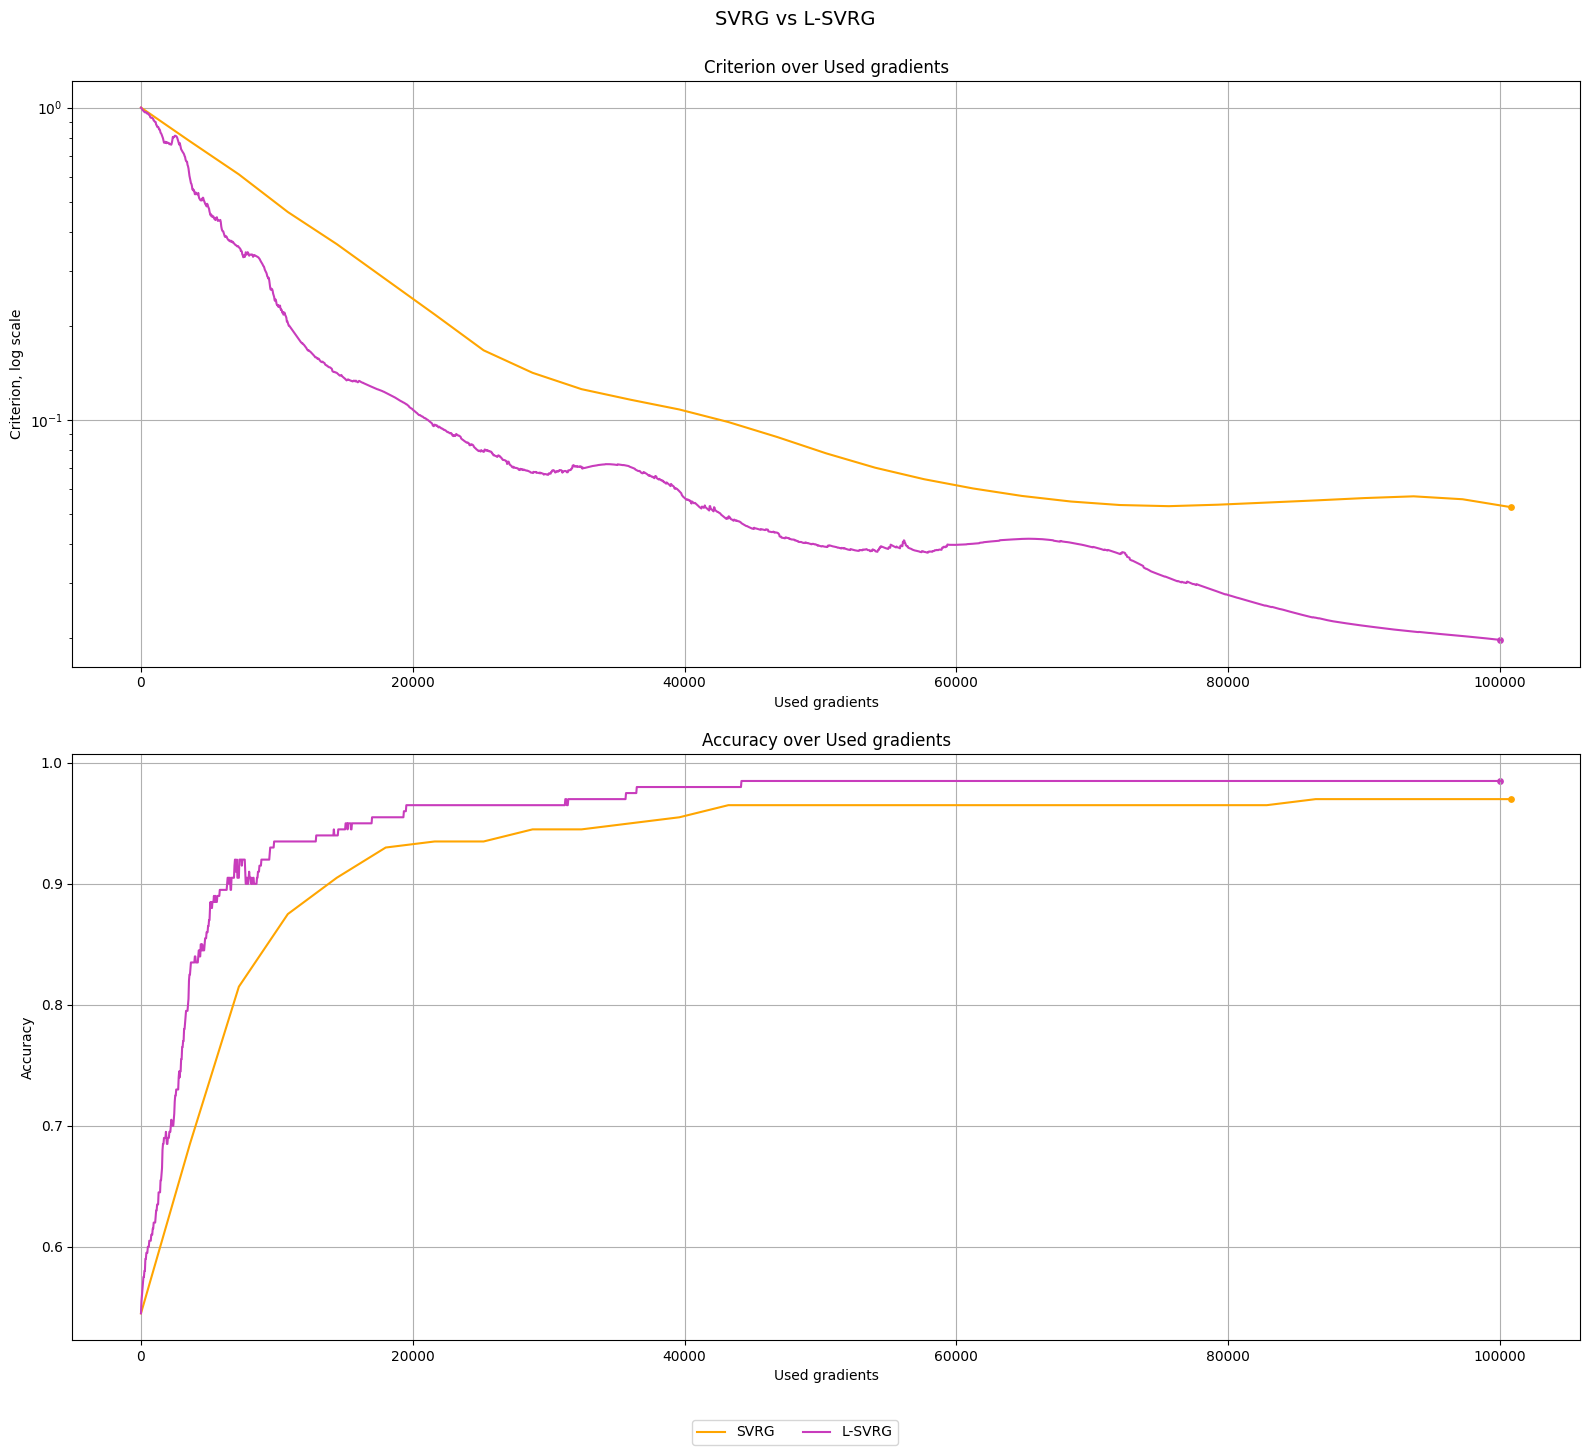

In [230]:
draw_method_plots(
    svrgs,
    plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
    title="SVRG vs L-SVRG",
)

### Ex2. SARAH vs PAGE


In [232]:
SARAH_LR_DICT: dict[str, Callable[[int], float]] = {
    "SARAH": lambda _: 1e-1,
    "PAGE": lambda _: 1e-1,
}

SARAH_B_SECONDARY = 10
SARAH_B_PRIMARY = SARAH_B_SECONDARY**2

SARAH_P = SARAH_B_SECONDARY / (SARAH_B_PRIMARY + SARAH_B_SECONDARY)


sarahs: list[Method] = [
    SARAH(
        BasicLogisticRegression(generate_batches(X_train, Y_train, SARAH_B_PRIMARY)),
        START_POINT,
        SARAH_LR_DICT["SARAH"],
        epoch_length=DATA_SIZE // SARAH_B_PRIMARY,
    ),
    PAGE(
        BasicLogisticRegression(generate_batches(X_train, Y_train, SARAH_B_SECONDARY)),
        START_POINT,
        SARAH_LR_DICT["PAGE"],
        probability=SARAH_P,
    ),
]

for sarah in sarahs:
    sarah.enable_accuracy_logging(X_test, Y_test)
    _ = sarah.start(max_iterations=1e5, iteration_type="gradients")

SARAH: 101910it [00:02, 47845.14it/s, time=0.035, criterion=0.127, accuracy=0.95]                               
PAGE: 100040it [00:51, 1950.67it/s, time=0.017, criterion=0.0146, accuracy=0.985]                               


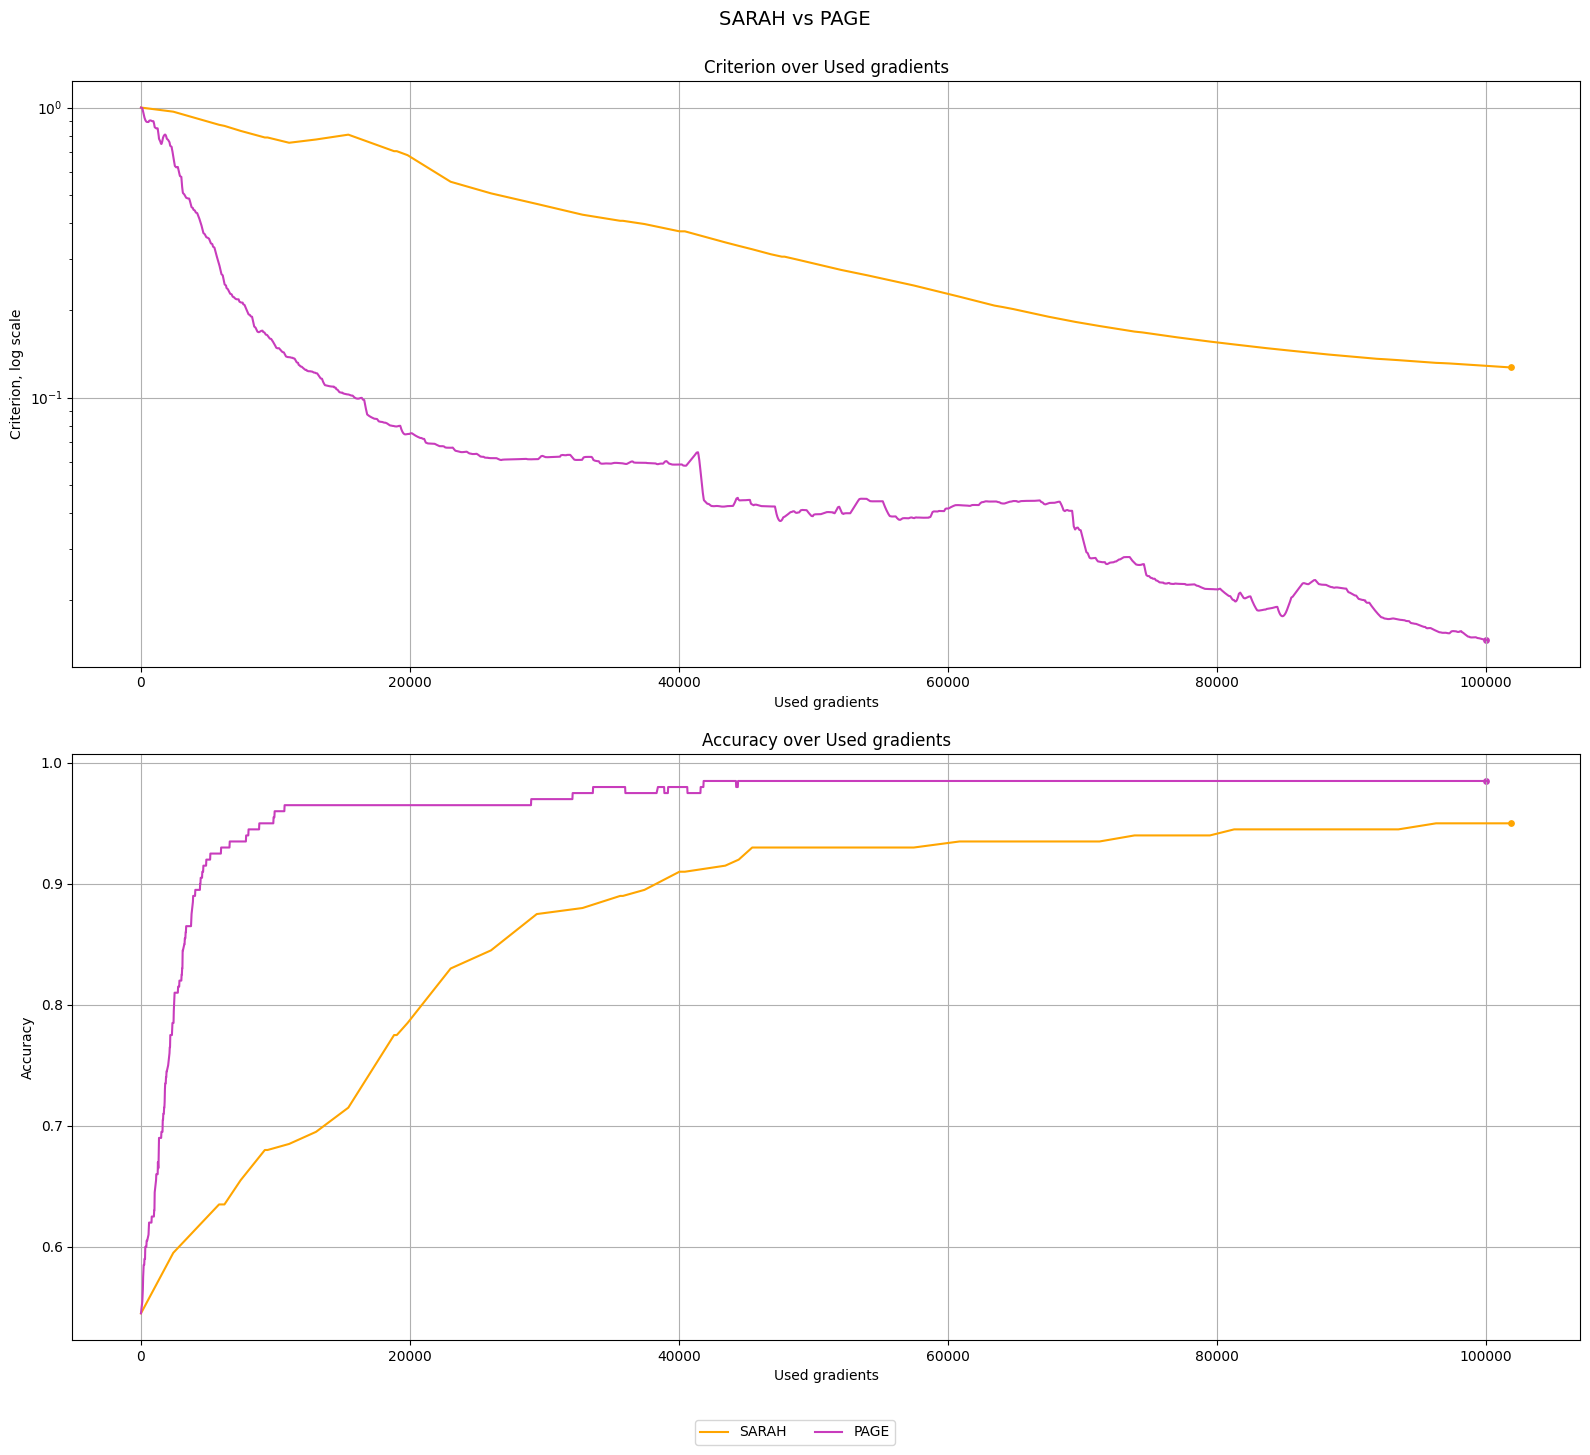

In [233]:
draw_method_plots(
    sarahs,
    plots=[("used_gradients", "criterion"), ("used_gradients", "accuracy")],
    title="SARAH vs PAGE",
)